In [2]:
import os
import json
import copy
import numpy as np
import pandas as pd
from utils import *
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

seed = 109

datasets = ['Korea_grip', 'Dutch_drinking_inh', 'Dutch_drinking_wm', 'Dutch_drinking_sha', 
            'Brazil_health_heart', 'Brazil_health_stroke', 'China_glucose_women2', 'China_glucose_men2', 
            'Spain_Hair', 'China_HIV']

sizes = {
    'Dutch_drinking_inh' : 12121,
    'Dutch_drinking_wm' : 12131,
    'Dutch_drinking_sha' : 12098,
    'Brazil_health_heart' : 7728,
    'Brazil_health_stroke' : 9675,
    'Korea_grip' : 1022,
    'China_glucose_women2' : 4568,
    'China_glucose_men2' : 4360,
    'Spain_Hair' : 529,
    'China_HIV' : 2410
}


p_cores  = [0.01, 0.05, 0.1, 0.15, 0.2]
alphas = [2 ** (i - 4) for i in range(10)]
refits   = [True]
speed_types  = ['same', 'scaled']

results_dict = {
    'beta' : {},
    'R'   : {},
    'mse' : {},
    'vol' : {},
    'inc' : {},
    'msevvol' : {},
    'msevinc' : {}
}

val_data = {}
test_data = {}

for dataset in datasets:
    val_data[dataset]  = {seed: copy.deepcopy(results_dict) for seed in range(100, 110)}
    test_data[dataset] = {seed: copy.deepcopy(results_dict) for seed in range(100, 110)}

In [3]:
dir = f'../data/regr/results/{seed}'
for filename in os.listdir(dir):
    if filename[-5:] != '.json':
        continue

    expt = filename[:-5]
    attributes = expt.split(',')

    dataset = attributes[0]
    n_core = attributes[1]
    alpha = attributes[2]
    speed_type = attributes[3]
    refit = attributes[4]
    val_or_test = attributes[5]
    # print(val_or_test)
    assert val_or_test in ['val', 'test']

    expt = expt[:-len(val_or_test)]
    with open(dir + '/' + filename) as file:
        data = json.load(file)
        if val_or_test == 'val':
            # print(expt, dataset)
            val_data[dataset]['beta'][expt] = data['beta']
            val_data[dataset]['R'][expt]    = data['R']
            val_data[dataset]['mse'][expt]  = data['mse']
            val_data[dataset]['vol'][expt]  = data['vol']
            val_data[dataset]['inc'][expt]  = data['inc']
            val_data[dataset]['msevvol'][expt] = data['msevvol']
            val_data[dataset]['msevinc'][expt] = data['msevinc']
            # print(dataset, val_data[dataset]['inc'].keys())

        else:
            # print(expt, dataset)
            test_data[dataset]['beta'][expt] = data['beta']
            test_data[dataset]['R'][expt]    = data['R']
            test_data[dataset]['mse'][expt]  = data['mse']
            test_data[dataset]['vol'][expt]  = data['vol']
            test_data[dataset]['inc'][expt]  = data['inc']
            test_data[dataset]['msevvol'][expt] = data['msevvol']
            test_data[dataset]['msevinc'][expt] = data['msevinc']

In [4]:
best_val_mse = {}
best_val_large_region_mse = {}
best_val_msevvol = {}
best_val_msevinc = {}

for dataset in datasets:
    best_val_mse[dataset]     = min(val_data[dataset]['mse'],     key = val_data[dataset]['mse'].get)
    best_val_msevvol[dataset] = min(val_data[dataset]['msevvol'], key = val_data[dataset]['msevvol'].get)
    best_val_msevinc[dataset] = min(val_data[dataset]['msevinc'], key = val_data[dataset]['msevinc'].get)

    val_size = int(sizes[dataset] * 0.5 * 0.4)
    includes_geq_5percent = []
    
    for expt in val_data[dataset]['inc']:
        if val_data[dataset]['inc'][expt] >= 0.05 * val_size:
            includes_geq_5percent.append(expt)
    
    large_regions = {expt: val_data[dataset]['mse'][expt] for expt in includes_geq_5percent}
    best_val_large_region_mse[dataset] = min(large_regions, key = large_regions.get)

# MSE/Inclusion results

In [10]:
summary_data = []

inc_df_data = []
mse_df_data = []

base_mses = {}

for dataset in datasets:
    X, Y, names_covariates = load_regr_data(dataset)
    n, d = X.shape
    X = np.concatenate([X, np.ones((len(X), 1))], axis = 1) # Add bias

    Y = StandardScaler().fit_transform(Y.reshape(-1, 1)).reshape(-1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=seed)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.4, random_state=seed)

    base_beta, _, _ = core_fit(X_train, Y_train)
    
    base_mse = np.mean((X_test @ base_beta - Y_test) ** 2)
    base_inc = len(X_test)

    base_mses[dataset] = base_mse
    # mse = best_val_mse[dataset]
    lrmse = best_val_large_region_mse[dataset]

    inc_summary = np.array([base_inc, test_data[dataset]["inc"][lrmse]]) / base_inc
    inc_df_data.append(inc_summary)
    mse_summary = np.array([base_mse, test_data[dataset]["mse"][lrmse]])
    mse_df_data.append(mse_summary)

    # inc_summary = np.around(inc_summary, 2)
    # mse_summary = np.around(mse_summary, 2)
    data = [f'{mse_summary[i]} ({inc_summary[i]})' for i in range(2)]
    # summary = pd.concat(summary, np.concatenate(inc_summary, mse_summary).around(3), axis = 0)
    # data =  np.around(np.concatenate([inc_summary, mse_summary]), 3)
    summary_data.append(data)

summary = pd.DataFrame(data = summary_data, index = datasets, columns = ['Base', 'LRMSE'])
# print(summary.to_latex())
display(HTML(summary.to_html()))
# summary.to_csv(f'../data/regr/results/summary,{seed}.csv')

inc_df = pd.DataFrame(data = inc_df_data, index = datasets, columns = ['Base', 'Us'])
inc_df.to_csv(f'../data/regr/mse_core_summary/inc,{seed}.csv')
mse_df = pd.DataFrame(data = mse_df_data, index = datasets, columns = ['Base', 'Us'])
mse_df.to_csv(f'../data/regr/mse_core_summary/mse,{seed}.csv')

,Base,LRMSE
Korea_grip,0.665801809566111 (1.0),0.44967043663962275 (0.2549019607843137)
Dutch_drinking_inh,0.6530322172334989 (1.0),0.3951430158946777 (0.057755775577557754)
Dutch_drinking_wm,0.7274183305132497 (1.0),0.606784113951326 (0.16680406705138776)
Dutch_drinking_sha,0.6928493255163227 (1.0),0.42640455111501907 (0.05235602094240838)
Brazil_health_heart,0.8070922179270443 (1.0),0.038566391474318146 (0.05306298533218291)
Brazil_health_stroke,1.918564052247638 (1.0),0.06044270045814404 (0.05513439007580979)
China_glucose_women2,0.764006855728863 (1.0),0.5120591742531355 (0.12627737226277372)
China_glucose_men2,0.867690607717663 (1.0),0.920209372554849 (0.08180428134556575)
Spain_Hair,0.8971416332341647 (1.0),0.7875698618611585 (0.6352201257861635)
China_HIV,0.8556117969922001 (1.0),0.7199684885774713 (0.2641770401106501)


# Coefficient/Region results

In [7]:
import statsmodels.api as sm

results = {}

for dataset in datasets:
    results[dataset] = {}

    best_mse = best_val_mse[dataset]
    best_lrmse = best_val_large_region_mse[dataset]
    best_msevvol = best_val_msevvol[dataset]
    best_msevinc = best_val_msevinc[dataset]
    
    X, Y, names_covariates = load_regr_data(dataset)
    B = np.column_stack([np.min(X, axis = 0) - 0.1, np.max(X, axis = 0) + 0.1])

    names_covariates = list(names_covariates)
    names_covariates.insert(0, 'Bias')
    X = sm.add_constant(X)
    Y = StandardScaler().fit_transform(Y.reshape(-1, 1)).reshape(-1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=seed)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.4, random_state=seed)

    base_R  = B
    mse_R   = np.array(val_data[dataset]['R'][best_mse])
    lrmse_R = np.array(val_data[dataset]['R'][best_lrmse])

    mse_ind = in_box(X_train[:, 1:], mse_R)
    lrmse_ind = in_box(X_train[:, 1:], lrmse_R)
    # msevvol_ind = in_box(X_train[:, :-1], np.array(val_data[dataset]['R'][best_msevvol]))
    # msevinc_ind = in_box(X_train[:, :-1], np.array(val_data[dataset]['R'][best_msevinc]))
    
    base_reg = sm.OLS(Y_train, X_train).fit()
    base_sig_coeffs = [i for i in range(len(base_reg.pvalues)) if base_reg.pvalues[i] < 0.05]
    base_beta = np.linalg.solve(X_train.T @ X_train, X_train.T @ Y_train)

    X_mse = X_train[mse_ind]
    Y_mse = Y_train[mse_ind]
    mse_reg = sm.OLS(Y_mse, X_mse).fit()
    mse_sig_coeffs = [i for i in range(len(mse_reg.pvalues)) if mse_reg.pvalues[i] < 0.05]

    X_lrmse = X_train[lrmse_ind]
    Y_lrmse = Y_train[lrmse_ind]
    lrmse_reg = sm.OLS(Y_lrmse, X_lrmse).fit()
    lrmse_sig_coeffs = [i for i in range(len(lrmse_reg.pvalues)) if lrmse_reg.pvalues[i] < 0.05]

    np.savetxt(f'../data/regr/mse_core_summary/{dataset},beta,base,{seed}.csv', base_reg.params, delimiter=",")
    np.savetxt(f'../data/regr/mse_core_summary/{dataset},pvals,base,{seed}.csv', base_reg.pvalues, delimiter=",")
    np.savetxt(f'../data/regr/mse_core_summary/{dataset},region,base,{seed}.csv', base_R, delimiter=",")

    np.savetxt(f'../data/regr/mse_core_summary/{dataset},beta,us,{seed}.csv', lrmse_reg.params, delimiter=",")
    np.savetxt(f'../data/regr/mse_core_summary/{dataset},pvals,us,{seed}.csv', lrmse_reg.pvalues, delimiter=",")
    np.savetxt(f'../data/regr/mse_core_summary/{dataset},region,us,{seed}.csv', lrmse_R, delimiter=",")

    # results[dataset]['coeffs'] = pd.DataFrame()
    coeffs = pd.DataFrame()
    region = pd.DataFrame()
    prec = 2

    for i, var in enumerate(names_covariates):
        coeffs[var] = [f'{round(base_reg.params[i], prec)}  ({round(base_reg.pvalues[i], prec)})', 
                       f'{round(mse_reg.params[i], prec)}  ({round(mse_reg.pvalues[i], prec)})',
                       f'{round(lrmse_reg.params[i], prec)}  ({round(lrmse_reg.pvalues[i], prec)})']
        if i > 0:
            region[var] = [(round(B[i - 1, 0], 3), round(B[i - 1, 1], 3)),
                           (round(mse_R[i - 1, 0], 3), round(mse_R[i - 1, 1], 3)),
                           (round(lrmse_R[i - 1, 0], 3), round(lrmse_R[i - 1, 1], 3))]
    coeffs.index = ['Base', 'MSE', 'LRMSE']
    region.index = ['Base', 'MSE', 'LRMSE']
    results[dataset]['coeffs'] = coeffs
    results[dataset]['R'] = region

    # print('----------------------------------------------------')
    # print(f'Data: {dataset}')
    # print('----------------------------------------------------')
    # print('Coeffs (weight, pval):')
    # print(coeffs)
    # print('----------------------------------------------------')
    # print('Region:')
    # print(region)
    # print('----------------------------------------------------')
    print('----------------------------------------------------')
    print(f'Data: {dataset}')
    print('----------------------------------------------------')
    # print(coeffs.T.to_latex())
    # print(region.T.to_latex())
    display(HTML(coeffs.T.to_html()))
    display(HTML(region.T.to_html()))

    # coeffs.T.to_csv(f'../data/regr/results/coeff,{dataset},{seed}.csv')
    # region.T.to_csv(f'../data/regr/results/region,{dataset},{seed}.csv')
    print('----------------------------------------------------')

----------------------------------------------------
Data: Korea_grip
----------------------------------------------------


,Base,MSE,LRMSE
Bias,0.02 (0.57),0.0 (0.88),0.0 (0.88)
total_s_hand,-0.12 (0.38),0.2 (0.57),0.2 (0.57)
JSN_hand,-0.06 (0.54),-0.36 (0.16),-0.36 (0.16)
OP_hand,0.02 (0.81),-0.13 (0.48),-0.13 (0.48)
total_s_knee,0.17 (0.52),0.58 (0.32),0.58 (0.32)
OP_knee,-0.08 (0.63),-0.33 (0.36),-0.33 (0.36)
JSN_knee,-0.18 (0.16),-0.38 (0.17),-0.38 (0.17)
age,-0.34 (0.0),-0.3 (0.0),-0.3 (0.0)
BMI,0.1 (0.01),0.17 (0.05),0.17 (0.05)
smoking_c,-0.03 (0.51),0.01 (0.88),0.01 (0.88)


,Base,MSE,LRMSE
total_s_hand,"(-2.796, 6.123)","(-2.796, 6.123)","(-2.796, 6.123)"
JSN_hand,"(-2.747, 3.533)","(-2.747, 3.533)","(-2.747, 3.533)"
OP_hand,"(-2.877, 5.334)","(-2.877, 5.334)","(-2.877, 5.334)"
total_s_knee,"(-2.456, 4.987)","(-2.456, 4.987)","(-2.456, 4.987)"
OP_knee,"(-2.474, 5.632)","(-2.474, 5.632)","(-2.474, 5.632)"
JSN_knee,"(-2.463, 2.673)","(-2.463, 2.673)","(-2.463, 2.673)"
age,"(-1.898, 3.61)","(-1.898, 3.61)","(-1.898, 3.61)"
BMI,"(-3.452, 4.225)","(-3.452, 4.225)","(-3.452, 4.225)"
smoking_c,"(-0.689, 1.799)","(-0.589, 1.699)","(-0.589, 1.699)"
alcohol_c,"(-1.545, 0.792)","(-1.545, 0.792)","(-1.545, 0.792)"


----------------------------------------------------
----------------------------------------------------
Data: Dutch_drinking_inh
----------------------------------------------------


,Base,MSE,LRMSE
Bias,-0.0 (0.97),-0.71 (0.01),-0.48 (0.02)
Imputation__1.0,-0.02 (0.59),0.26 (0.15),0.08 (0.61)
Imputation__2.0,0.02 (0.7),0.16 (0.38),0.19 (0.23)
Imputation__3.0,-0.01 (0.76),0.24 (0.21),0.08 (0.61)
Imputation__4.0,0.04 (0.39),-0.14 (0.46),0.04 (0.77)
Imputation__5.0,-0.04 (0.4),0.31 (0.1),0.2 (0.22)
t1inh,0.59 (0.0),0.42 (0.0),0.55 (0.0)
sex,0.08 (0.0),0.14 (0.01),0.13 (0.0)
t1age,0.0 (0.94),-0.09 (0.27),-0.04 (0.55)
t1ses,0.08 (0.0),0.06 (0.51),0.08 (0.27)


,Base,MSE,LRMSE
Imputation__1.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.0)"
Imputation__2.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.0)"
Imputation__3.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.0)"
Imputation__4.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
Imputation__5.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.0)"
t1inh,"(-3.635, 9.746)","(-3.635, 0.575)","(-1.406, 0.982)"
sex,"(-1.077, 1.124)","(-0.977, 1.124)","(-0.977, 1.124)"
t1age,"(-2.251, 2.626)","(-0.668, 1.503)","(-0.668, 1.397)"
t1ses,"(-2.483, 2.317)","(0.173, 2.317)","(-0.043, 2.317)"
t1mat_alcohol,"(-1.518, 2.709)","(-1.518, 0.193)","(-1.518, 0.998)"


----------------------------------------------------
----------------------------------------------------
Data: Dutch_drinking_wm
----------------------------------------------------


,Base,MSE,LRMSE
Bias,-0.05 (0.18),-0.18 (0.12),-0.12 (0.18)
Imputation__1.0,0.07 (0.11),0.31 (0.15),0.19 (0.05)
Imputation__2.0,0.03 (0.44),0.35 (0.11),0.14 (0.12)
Imputation__3.0,0.06 (0.17),0.46 (0.04),0.07 (0.44)
Imputation__4.0,0.0 (0.97),0.31 (0.18),0.1 (0.31)
Imputation__5.0,0.05 (0.31),0.48 (0.04),0.25 (0.01)
t1wm,0.54 (0.0),0.53 (0.0),0.5 (0.0)
sex,-0.02 (0.05),-0.19 (0.12),0.0 (0.89)
t1age,-0.03 (0.02),0.11 (0.32),0.03 (0.55)
t1ses,0.05 (0.0),0.22 (0.01),0.06 (0.07)


,Base,MSE,LRMSE
Imputation__1.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
Imputation__2.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.0)"
Imputation__3.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
Imputation__4.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
Imputation__5.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
t1wm,"(-2.68, 7.309)","(-2.68, 0.505)","(-2.68, 0.748)"
sex,"(-1.076, 1.124)","(-0.976, 1.124)","(-0.976, 1.124)"
t1age,"(-2.251, 2.626)","(-1.516, 0.267)","(-1.516, 0.302)"
t1ses,"(-2.482, 2.318)","(-0.862, 1.225)","(-0.979, 1.547)"
t1mat_alcohol,"(-1.518, 2.709)","(-1.418, 0.193)","(-1.418, 0.998)"


----------------------------------------------------
----------------------------------------------------
Data: Dutch_drinking_sha
----------------------------------------------------


,Base,MSE,LRMSE
Bias,0.0 (0.96),0.14 (0.3),0.14 (0.3)
Imputation__1.0,-0.0 (0.92),-0.15 (0.24),-0.15 (0.24)
Imputation__2.0,0.02 (0.68),-0.04 (0.76),-0.04 (0.76)
Imputation__3.0,0.02 (0.68),-0.04 (0.74),-0.04 (0.74)
Imputation__4.0,0.0 (0.91),-0.13 (0.33),-0.13 (0.33)
Imputation__5.0,0.02 (0.68),0.06 (0.67),0.06 (0.67)
t1sha,0.59 (0.0),0.62 (0.0),0.62 (0.0)
sex,0.11 (0.0),0.18 (0.0),0.18 (0.0)
t1age,-0.02 (0.02),0.05 (0.18),0.05 (0.18)
t1ses,0.04 (0.0),0.15 (0.07),0.15 (0.07)


,Base,MSE,LRMSE
Imputation__1.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
Imputation__2.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
Imputation__3.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
Imputation__4.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
Imputation__5.0,"(-0.1, 1.1)","(-0.1, 1.0)","(-0.1, 1.0)"
t1sha,"(-3.992, 6.458)","(-1.204, 0.161)","(-1.204, 0.161)"
sex,"(-1.078, 1.122)","(-1.078, 1.022)","(-1.078, 1.022)"
t1age,"(-2.252, 2.625)","(-1.393, 2.625)","(-1.393, 2.625)"
t1ses,"(-2.483, 2.318)","(-0.565, 0.718)","(-0.565, 0.718)"
t1mat_alcohol,"(-1.517, 2.709)","(-1.517, 2.709)","(-1.517, 2.709)"


----------------------------------------------------
----------------------------------------------------
Data: Brazil_health_heart
----------------------------------------------------


,Base,MSE,LRMSE
Bias,-0.0 (0.73),-1.06 (0.21),-0.57 (0.0)
Year,-0.23 (0.0),-0.15 (0.66),-0.07 (0.0)
ESFProportion,0.01 (0.7),-0.46 (0.7),0.03 (0.56)
ACSProportion,-0.03 (0.25),-0.18 (0.86),-0.0 (0.91)
Population,-0.05 (0.0),-0.11 (0.59),-0.01 (0.02)
GDP,-0.05 (0.0),-0.34 (0.54),-0.01 (0.31)
DHI Value,-0.1 (0.0),0.19 (0.67),-0.0 (0.79)


,Base,MSE,LRMSE
Year,"(-1.692, 1.697)","(-1.692, 0.727)","(-1.302, 1.697)"
ESFProportion,"(-1.062, 1.576)","(-1.062, 1.576)","(-1.062, 1.576)"
ACSProportion,"(-1.193, 1.42)","(-1.193, 1.42)","(-1.193, 1.42)"
Population,"(-0.238, 26.016)","(0.235, 1.432)","(0.195, 26.016)"
GDP,"(-0.957, 18.731)","(0.279, 18.731)","(-0.957, 18.731)"
DHI Value,"(-3.151, 4.357)","(0.889, 1.618)","(-3.151, 4.357)"


----------------------------------------------------
----------------------------------------------------
Data: Brazil_health_stroke
----------------------------------------------------


,Base,MSE,LRMSE
Bias,0.0 (0.86),-0.12 (0.72),-0.27 (0.0)
Year,-0.09 (0.0),0.16 (0.82),-0.02 (0.21)
ESFProportion,-0.04 (0.05),0.48 (0.59),-0.14 (0.03)
ACSProportion,0.06 (0.01),-0.13 (0.78),0.16 (0.0)
Population,-0.02 (0.06),-0.01 (0.6),-0.01 (0.15)
GDP,-0.04 (0.0),-0.24 (0.75),-0.01 (0.68)
DHI Value,-0.11 (0.0),0.06 (0.8),-0.05 (0.03)


,Base,MSE,LRMSE
Year,"(-1.72, 1.72)","(-1.72, 1.72)","(-1.157, 1.72)"
ESFProportion,"(-1.131, 1.496)","(-1.131, 1.496)","(-1.131, 0.68)"
ACSProportion,"(-1.277, 1.334)","(-1.277, 1.334)","(-1.277, 1.334)"
Population,"(-0.238, 26.151)","(2.796, 26.151)","(0.161, 26.151)"
GDP,"(-0.976, 19.143)","(-0.976, 19.143)","(-0.46, 19.143)"
DHI Value,"(-3.262, 4.125)","(-3.262, 4.125)","(0.286, 4.125)"


----------------------------------------------------
----------------------------------------------------
Data: China_glucose_women2
----------------------------------------------------


,Base,MSE,LRMSE
Bias,0.02 (0.4),0.32 (0.63),0.01 (0.91)
FPG,0.11 (0.0),0.27 (0.15),-0.13 (0.18)
Age,0.04 (0.15),0.17 (0.62),0.02 (0.79)
BMI,0.06 (0.01),-0.06 (0.84),-0.02 (0.81)
SBP,0.03 (0.39),0.35 (0.35),0.23 (0.02)
DBP,0.02 (0.48),0.06 (0.89),-0.11 (0.19)
TC,0.07 (0.0),0.49 (0.16),0.16 (0.03)
TG,0.05 (0.01),0.33 (0.41),0.22 (0.1)
Drinker(N0/Y1),-0.01 (0.66),-0.04 (0.63),-0.03 (0.42)
Smoker(N0/Y1),0.02 (0.37),-0.05 (0.63),0.15 (0.0)


,Base,MSE,LRMSE
FPG,"(-1.757, 2.135)","(-1.393, 1.771)","(-1.757, -0.075)"
Age,"(-2.168, 2.534)","(-1.693, 0.483)","(-2.168, 0.934)"
BMI,"(-3.014, 10.966)","(-1.467, -0.047)","(-3.014, 1.035)"
SBP,"(-2.401, 5.239)","(-1.572, 0.179)","(-2.401, 0.665)"
DBP,"(-2.983, 5.419)","(-2.983, -0.089)","(-2.342, 5.419)"
TC,"(-3.014, 9.279)","(-1.085, 0.556)","(-3.014, 0.629)"
TG,"(-1.288, 22.438)","(-1.288, 0.288)","(-1.288, 0.309)"
Drinker(N0/Y1),"(-0.213, 8.918)","(-0.213, 8.918)","(-0.213, 8.918)"
Smoker(N0/Y1),"(-0.25, 6.75)","(-0.25, 6.75)","(-0.25, 6.75)"
eGFR,"(-4.79, 8.738)","(0.247, 1.938)","(-4.79, 1.225)"


----------------------------------------------------
----------------------------------------------------
Data: China_glucose_men2
----------------------------------------------------


,Base,MSE,LRMSE
Bias,-0.01 (0.71),-0.07 (0.86),-0.36 (0.01)
FPG,0.07 (0.0),-0.02 (0.96),-0.15 (0.21)
Age,-0.02 (0.5),0.26 (0.46),-0.02 (0.85)
BMI,0.04 (0.03),0.03 (0.9),0.1 (0.44)
SBP,-0.01 (0.68),-0.17 (0.48),-0.01 (0.92)
DBP,0.03 (0.26),0.18 (0.3),-0.11 (0.31)
TC,0.03 (0.11),0.59 (0.08),-0.0 (0.99)
TG,0.02 (0.24),-0.09 (0.81),-0.07 (0.69)
Drinker(N0/Y1),0.04 (0.09),0.09 (0.53),0.18 (0.01)
Smoker(N0/Y1),-0.03 (0.19),-0.05 (0.72),-0.07 (0.29)


,Base,MSE,LRMSE
FPG,"(-1.812, 2.049)","(-1.712, 0.259)","(-1.812, 0.259)"
Age,"(-2.013, 2.308)","(0.01, 1.384)","(-0.47, 2.308)"
BMI,"(-2.522, 24.05)","(-0.763, 1.245)","(-0.085, 2.338)"
SBP,"(-2.306, 5.671)","(-1.088, 1.043)","(-2.306, 2.108)"
DBP,"(-4.241, 5.042)","(-4.241, 5.042)","(-1.354, 1.794)"
TC,"(-3.176, 9.296)","(-0.976, 0.382)","(-2.132, 1.061)"
TG,"(-0.94, 15.111)","(-0.94, 0.872)","(-0.94, 1.043)"
Drinker(N0/Y1),"(-0.612, 2.054)","(-0.612, 1.954)","(-0.612, 1.954)"
Smoker(N0/Y1),"(-1.004, 1.206)","(-1.004, 1.106)","(-1.004, 1.106)"
eGFR,"(-4.15, 3.301)","(-1.613, -0.045)","(-4.15, 0.59)"


----------------------------------------------------
----------------------------------------------------
Data: Spain_Hair
----------------------------------------------------


,Base,MSE,LRMSE
Bias,0.01 (0.88),0.2 (0.05),0.2 (0.05)
Age,-0.02 (0.83),-0.04 (0.72),-0.04 (0.72)
Education,0.15 (0.05),0.19 (0.12),0.19 (0.12)
EmploymentS,-0.13 (0.18),0.24 (0.11),0.24 (0.11)
HairDye,-0.07 (0.26),-0.02 (0.7),-0.02 (0.7)
PhysicalAct,0.11 (0.09),0.05 (0.46),0.05 (0.46)


,Base,MSE,LRMSE
Age,"(-1.377, 3.615)","(-1.377, 3.615)","(-1.377, 3.615)"
Education,"(-1.762, 0.912)","(-0.837, 0.812)","(-0.837, 0.812)"
EmploymentS,"(-1.311, 2.333)","(-1.311, -0.063)","(-1.311, -0.063)"
HairDye,"(-0.531, 2.418)","(-0.531, 2.418)","(-0.531, 2.418)"
PhysicalAct,"(-1.022, 1.185)","(-1.022, 1.085)","(-1.022, 1.085)"


----------------------------------------------------
----------------------------------------------------
Data: China_HIV
----------------------------------------------------


,Base,MSE,LRMSE
Bias,-0.21 (0.09),0.33 (0.1),0.33 (0.1)
route_2.0,-0.07 (0.44),-0.14 (0.31),-0.14 (0.31)
route_3.0,0.12 (0.18),-0.11 (0.39),-0.11 (0.39)
route_4.0,0.14 (0.62),-0.11 (0.8),-0.11 (0.8)
route_5.0,0.25 (0.03),0.17 (0.32),0.17 (0.32)
route_6.0,-0.27 (0.39),-0.98 (0.19),-0.98 (0.19)
route_7.0,-0.07 (0.41),-0.24 (0.05),-0.24 (0.05)
sex_2,0.04 (0.64),-0.2 (0.14),-0.2 (0.14)
ethni_2.0,-0.02 (0.69),-0.03 (0.77),-0.03 (0.77)
ethni_3.0,0.29 (0.05),0.59 (0.01),0.59 (0.01)


,Base,MSE,LRMSE
route_2.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
route_3.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
route_4.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
route_5.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
route_6.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
route_7.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
sex_2,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
ethni_2.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
ethni_3.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"
relig_2.0,"(-0.1, 1.1)","(-0.1, 1.1)","(-0.1, 1.1)"


----------------------------------------------------


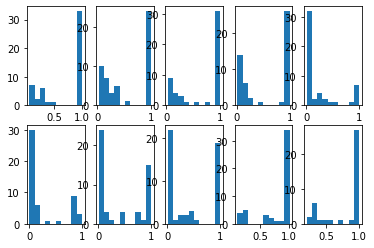

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5)
for ind, dataset in enumerate(datasets):
    dataset = datasets[ind]
    i = int(ind / 5)
    j = ind % 5
    val_size = int(sizes[dataset] * 0.5 * 0.4)
    hist = [val_data[dataset]['inc'][expt] / val_size for expt in val_data[dataset]['inc']]
    ax[i, j].hist(hist)

# MSE vs. region size

In [5]:
val_incl_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

best_val_large_region = {dataset: {p: {} for p in val_incl_sizes} for dataset in datasets}

for dataset in datasets:
    val_size = int(sizes[dataset] * 0.5 * 0.4)
    includes_geq_p = {p: [] for p in val_incl_sizes}

    for p in val_incl_sizes:

        for expt in val_data[dataset]['inc']:
            if val_data[dataset]['inc'][expt] >= p * val_size:
                includes_geq_p[p].append(expt)
        
        large_regions = {expt: val_data[dataset]['mse'][expt] for expt in includes_geq_p[p]}
        best_val_large_region[dataset][p] = min(large_regions, key=large_regions.get)

In [11]:
import matplotlib.pyplot as plt
%matplotlib auto
fig, axs = plt.subplots(5, 2, sharex=True)

for i, dataset in enumerate(datasets):
    test_size = int(sizes[dataset] * 0.5 * 0.6)
    base_mse = base_mses[dataset]
    inc = [test_data[dataset]['inc'][best_val_large_region[dataset][p]] / test_size for p in val_incl_sizes]
    mse = [test_data[dataset]['mse'][best_val_large_region[dataset][p]] / base_mse for p in val_incl_sizes]
    axs[i // 2, i % 2].plot(inc, mse)
    axs[i // 2, i % 2].set_title(dataset)

axs[4, 0].set_xlabel('Frac. of test points incl.', fontsize=16)
axs[4, 1].set_xlabel('Frac. of test points incl.', fontsize=16)
axs[2, 0].set_ylabel('Group MSE / Baseline MSE', fontsize=16)

Using matplotlib backend: MacOSX


Text(0, 0.5, 'Group MSE / Baseline MSE')

# Multi-seed results

In [19]:
for dataset in datasets:
    val_data[dataset]  = {seed: copy.deepcopy(results_dict) for seed in range(100, 110)}
    test_data[dataset] = {seed: copy.deepcopy(results_dict) for seed in range(100, 110)}

base_mses = {dataset: {} for dataset in datasets}
for dataset in datasets:
    X, Y, names_covariates = load_regr_data(dataset)
    n, d = X.shape
    X = np.concatenate([X, np.ones((len(X), 1))], axis = 1) # Add bias
    Y = StandardScaler().fit_transform(Y.reshape(-1, 1)).reshape(-1)

    for seed in range(100, 110):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=seed)
        X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.4, random_state=seed)

        base_beta, _, _ = core_fit(X_train, Y_train)
        base_mse = np.mean((X_test @ base_beta - Y_test) ** 2)
        base_mses[dataset][seed] = base_mse

for seed in tqdm(range(100, 110)):
    dir = f'../data/regr/results/{seed}'
    for filename in os.listdir(dir):
        if filename[-5:] != '.json':
            continue

        expt = filename[:-5]
        attributes = expt.split(',')

        dataset = attributes[0]
        n_core = attributes[1]
        alpha = attributes[2]
        speed_type = attributes[3]
        refit = attributes[4]
        val_or_test = attributes[5]
        # print(val_or_test)
        assert val_or_test in ['val', 'test']

        expt = expt[:-len(val_or_test)]
        with open(dir + '/' + filename) as file:
            data = json.load(file)
            if val_or_test == 'val':
                # print(expt, dataset)
                val_data[dataset][seed]['beta'][expt] = data['beta']
                val_data[dataset][seed]['R'][expt]    = data['R']
                val_data[dataset][seed]['mse'][expt]  = data['mse']
                val_data[dataset][seed]['vol'][expt]  = data['vol']
                val_data[dataset][seed]['inc'][expt]  = data['inc']
                val_data[dataset][seed]['msevvol'][expt] = data['msevvol']
                val_data[dataset][seed]['msevinc'][expt] = data['msevinc']
                # print(dataset, val_data[dataset]['inc'].keys())

            else:
                # print(expt, dataset)
                test_data[dataset][seed]['beta'][expt] = data['beta']
                test_data[dataset][seed]['R'][expt]    = data['R']
                test_data[dataset][seed]['mse'][expt]  = data['mse']
                test_data[dataset][seed]['vol'][expt]  = data['vol']
                test_data[dataset][seed]['inc'][expt]  = data['inc']
                test_data[dataset][seed]['msevvol'][expt] = data['msevvol']
                test_data[dataset][seed]['msevinc'][expt] = data['msevinc']

best_val_mse = {dataset: {} for dataset in datasets}
best_val_large_region_mse = {dataset: {} for dataset in datasets}
best_val_msevvol = {dataset: {} for dataset in datasets}
best_val_msevinc = {dataset: {} for dataset in datasets}

for dataset in datasets:
    for seed in range(100, 110):
        best_val_mse[dataset][seed]     = min(val_data[dataset][seed]['mse'],     key = val_data[dataset][seed]['mse'].get)
        best_val_msevvol[dataset][seed] = min(val_data[dataset][seed]['msevvol'], key = val_data[dataset][seed]['msevvol'].get)
        best_val_msevinc[dataset][seed] = min(val_data[dataset][seed]['msevinc'], key = val_data[dataset][seed]['msevinc'].get)

        val_size = int(sizes[dataset] * 0.5 * 0.4)
        includes_geq_5percent = []
        
        for expt in val_data[dataset][seed]['inc']:
            if val_data[dataset][seed]['inc'][expt] >= 0.05 * val_size:
                includes_geq_5percent.append(expt)
        
        large_regions = {expt: val_data[dataset][seed]['mse'][expt] for expt in includes_geq_5percent}
        best_val_large_region_mse[dataset][seed] = min(large_regions, key = large_regions.get)

100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


In [20]:
val_incl_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

best_val_large_region = {dataset: {seed: {p: {} for p in val_incl_sizes} for seed in range(100, 110)} for dataset in datasets}

for dataset in datasets:
    val_size = int(sizes[dataset] * 0.5 * 0.4)
    for seed in range(100, 110):
        for p in val_incl_sizes:
            includes_geq_p = []
            for expt in val_data[dataset][seed]['inc']:
                if val_data[dataset][seed]['inc'][expt] >= p * val_size:
                    includes_geq_p.append(expt)
            
            if includes_geq_p != []:
                large_regions = {expt: val_data[dataset][seed]['mse'][expt] for expt in includes_geq_p}
                best_val_large_region[dataset][seed][p] = min(large_regions, key=large_regions.get)
            else:
                best_val_large_region[dataset][seed][p] = 'base'

In [31]:
import matplotlib.pyplot as plt
%matplotlib auto
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
fig, axs = plt.subplots(3, 3, sharex=True)

plot_datasets = ['Korea_grip', 'Dutch_drinking_inh', 'Dutch_drinking_wm', 'Dutch_drinking_sha', 
            'Brazil_health_heart', 'Brazil_health_stroke', 'China_glucose_women2', 'China_glucose_men2', 
            'China_HIV']


for i, dataset in enumerate(plot_datasets):
    test_size = int(sizes[dataset] * 0.5 * 0.6)
    for seed in range(100, 110):
        base_mse = base_mses[dataset][seed]
        inc = []
        mse = []
        for p in val_incl_sizes:
            if best_val_large_region[dataset][seed][p] != 'base':
                inc.append(test_data[dataset][seed]['inc'][best_val_large_region[dataset][seed][p]] / test_size)
                mse.append(test_data[dataset][seed]['mse'][best_val_large_region[dataset][seed][p]] / base_mse)
            else:
                inc.append(1.0)
                mse.append(1.0)
        # inc = [test_data[dataset][seed]['inc'][best_val_large_region[dataset][seed][p]] / test_size for p in val_incl_sizes]
        # mse = [test_data[dataset][seed]['mse'][best_val_large_region[dataset][seed][p]] / base_mse for p in val_incl_sizes]
        axs[i // 3, i % 3].scatter(inc, mse)
        axs[i // 3, i % 3].set_title(dataset, fontsize=16)
        axs[i // 3, i % 3].tick_params(axis='both', which='major', labelsize=14)


axs[2, 1].set_xlabel('Frac. of test points incl.', fontsize=20)
# axs[4, 1].set_xlabel('Frac. of test points incl.', fontsize=16)
axs[1, 0].set_ylabel('Group MSE / Baseline MSE', fontsize=20)

Using matplotlib backend: MacOSX


Text(0, 0.5, 'Group MSE / Baseline MSE')